<center> <a href = Models.ipynb>ML Model Use &lt;</a> | <a href = Struggles.ipynb>&gt; User Struggles</a> <center>

# What visualization tools are people using and how?

## Results Summary:
- Matplotlib is by far the most popular visualization tool. It is over 10 times frequent than the next most popular, which is seaborn.
- Within Matplotlib, plot (y vs x line plot) is by far the most popular plot type. Following that is imshow (displays an image or a colormap, depending on parameters) and scatter (y vs x scatter plot). About half as popular as imshow and scatter is hist (histogram of one variable). Other plotting methods are less popular.
- The proportion of notebooks that use matplotlib had high variation in early months, likely due to the small number of notebooks. The popularity has grown dramatically from about 10% in June 2013 and looks to be converging to about 42% of all notebooks importing Matplotlib.
- On average, there are 5.1 matplotlib visualizations per notebook.
----------

# Import Packages and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import re

import load_data
import datetime
import pickle

Load dataframes.

In [2]:
notebooks_temp = load_data.load_notebooks(type = 'vis')
repos_temp = load_data.load_repos()
code_temp = load_data.load_code()
nb_imports_df_temp = load_data.load_nb_imports()

Notebooks (vis) loaded in 0:00:06.297915
Repos loaded in 0:00:05.867840
Code loaded in 0:01:22.575548
Notebook imports loaded in 0:01:21.691770


Load list. Code used to create it is in [aggregate.py](aggregate.py).

In [3]:
all_vis_uses = load_data.load_vis_uses()

Visualization counts loaded in 0:00:12.183236


---
# Tidy Data

### Only looking at Python notebooks

In [4]:
notebooks = notebooks_temp.copy()[notebooks_temp.lang_name == 'python'].reset_index(drop=True)

In [5]:
print("{0:,} ({1}%) of notebooks not in ipynb checkpoints were written in Python. The remaining {2}% have been removed.".format(
    len(notebooks),
    round(100*len(notebooks)/len(notebooks_temp), 2),
    round(100 - 100*len(notebooks)/len(notebooks_temp), 2)
))

4,322,201 (96.05%) of notebooks not in ipynb checkpoints were written in Python. The remaining 3.95% have been removed.


### Update repos and aggregated dataframe to reflect notebooks in question

All python notebooks not in ipynb checkpoints

In [6]:
repos = repos_temp.copy()[repos_temp.repo_id.isin(notebooks.repo_id)]
code = code_temp.copy()[code_temp.file.isin(notebooks.file)]
nb_imports_df = nb_imports_df_temp.copy()[nb_imports_df_temp.file.isin(notebooks.file)]

### Delete temp dataframes to save space

In [7]:
del notebooks_temp
del repos_temp
del code_temp
del nb_imports_df_temp

---
# Data Manipulation

### Visualization Package Use

In [8]:
# 1.5 minutes
start = datetime.datetime.now()

vis = ['matplotlib','altair','seaborn',
       'ggplot','bokeh','pygal','plotly',
       'geoplotlib','gleam','missingno',
       'leather']

vis_counts = pd.Series(
    [v.split('.')[0] for v in all_vis_uses if v.split('.')[0] in vis]
).value_counts().reset_index().rename(
    columns={'index':'Package',0:'Count'}
)

end = datetime.datetime.now()
print(end - start)

0:00:56.326482


### Monthly package use

In [9]:
monthly_vis_counts = notebooks.groupby(
    ['month','year']
)[vis].sum().reset_index().sort_values(
    by = ['year','month']
).reset_index(drop=True).merge(
    notebooks.groupby(['month','year'])['file'].count().reset_index().rename(
        columns = {'file':'total'}
    ),
    on = ['month','year']
)

monthly_vis_counts['label'] = [
    datetime.date(int(row['year']), int(row['month']), 1).strftime('%b %Y') 
    if row['month'] == 1 else ''
    for _, row in monthly_vis_counts.iterrows()
]

### Types of matplotlib pyplot plots

In [10]:
matplotlib_plots = {
    'matplotlib.pyplot.plot':'plot',
    'matplotlib.pyplot.semilogx':'plot', #same as plot but with xscale = log
    'matplotlib.pyplot.semilogy':'plot', #same as plot but with yscale = log
    'matplotlib.pyplot.loglog':'plot',   #same as plot but with xscale = log, yscale = log
    'matplotlib.pyplot.scatter':'scatter',
    'matplotlib.pyplot.hist':'hist',
    'matplotlib.pyplot.bar':'bar',
    'matplotlib.pyplot.colorbar':'colorbar',
    'matplotlib.pyplot.imshow':'imshow',
    'matplotlib.pyplot.boxplot':'boxplot',
    'matplotlib.pyplot.step':'step'
}

In [11]:
matplotlib_plot_counts = pd.Series([
    matplotlib_plots[v]
    for v in all_vis_uses if v in matplotlib_plots
]).value_counts().reset_index().rename(
        columns={'index':'Plot Type', 0:'Count'}
)

### Types of seaborn plots

In [12]:
seaborn_plots = {
    'seaborn.distplot': 'hist',
    'seaborn.heatmap': 'heatmap',
    'seaborn.countplot': 'bar',
    'seaborn.boxplot': 'boxplot',
    'seaborn.barplot': 'bar',
    'seaborn.pairplot': 'pairplot',
    'seaborn.lmplot': 'plot',
    'seaborn.jointplot': 'jointplot', # scatter plot + histograms on the sides
    'seaborn.kdeplot': 'hist',
    'seaborn.regplot': 'plot',
    'seaborn.pointplot': 'pointplot',
    'seaborn.violinplot': 'boxplot'
}

In [13]:
seaborn_plot_counts = pd.Series([
    seaborn_plots[v]
    for v in all_vis_uses if v in seaborn_plots
]).value_counts().reset_index().rename(
        columns={'index':'Plot Type', 0:'Count'}
)

## Types of altiar plots

In [14]:
nb_imports_altair_df = nb_imports_df[[
    'altair' in [im[0] for im in imports] 
    for imports in nb_imports_df.imports
]]

code_altair = code[code.file.isin(nb_imports_altair_df.file)].merge(nb_imports_altair_df, on = 'file')

In [15]:
def find_use(code, alt_alias):
    uses = []
    code = re.sub('(?<![a-zA-Z_])'+alt_alias+'(?![a-zA-Z_])','altair',code)
    whole_uses = re.findall('altair\.[a-zA-Z\._\(\)]+', code)
    for use in whole_uses:
        uses += re.findall('mark_[a-zA-Z_]+',use)
    return uses

altair_uses = []
for i in range(len(code_altair)):
    alt_alias = [a for a in code_altair.imports[i] if a[0] == 'altair'][0][1]
    code = '\n'.join([c for c in code_altair.code[i] if type(c) == str])
    uses = find_use(code, alt_alias)
    altair_uses.append(uses)

In [16]:
alt_plots = {
    'mark_point': 'scatter',
    'mark_line': 'plot',
    'mark_circle': 'scatter',
    'mark_bar': 'bar',
    'mark_rule': 'rule',
    'mark_area': 'area',
    'mark_tick': 'tick',
    'mark_text': 'text',
    'mark_geoshape': 'geoscape',
    'mark_rect': 'heatmap',
    'mark_square': 'scatter',
    'mark_boxplot': 'boxplot'
}

In [17]:
altair_plot_counts = pd.Series([
    alt_plots[v]
    for v in load_data.flatten(altair_uses) if v in alt_plots
]).value_counts().reset_index().rename(
        columns={'index':'Plot Type', 0:'Count'}
)

---
# Visualizations and Statistics

## Package Use

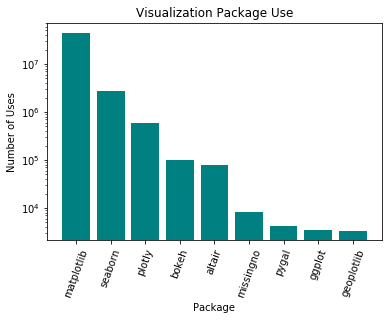

In [18]:
vis_counts_to_plot = vis_counts[vis_counts['Count'] > 100]

x = vis_counts_to_plot['Package']
x_pos = np.arange(len(x))
height = vis_counts_to_plot['Count']

plt.bar(x_pos, height, color = 'teal')
plt.xticks(x_pos, x, rotation = 70)
plt.xlabel('Package')
plt.ylabel('Number of Uses')
plt.title('Visualization Package Use')
plt.yscale('log')
plt.show()

Matplotlib is by far the most popular visualization tool. It is over 10 times frequent than the next mot popular, which is seaborn.

## Uses within packages

In [19]:
def get_counts(package):
    return pd.Series(['.'.join(v.split('.')[1:]) for v in all_vis_uses 
               if v.startswith(package) and '.' in v
    ]).value_counts().reset_index().rename(columns={'index':'use', 0:'count'})

In [20]:
def plot_package(package):
    counts = get_counts(package)
    x = counts['use'][:20]
    x_pos = np.arange(len(x))
    y = counts['count'][:20]
    
    plt.bar(x_pos, y, color = 'teal')
    plt.xticks(x_pos, x, rotation = 70, ha = 'right')
    plt.title('Use of {0}'.format(package.title()))
    plt.xlabel('Use')
    plt.ylabel('Number of Uses')
    plt.show()

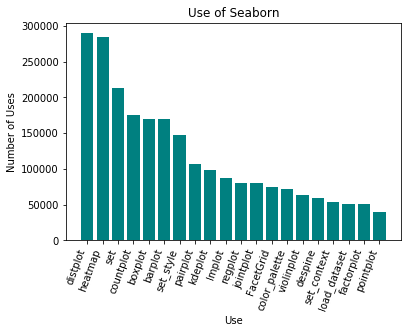

In [21]:
plot_package('seaborn')

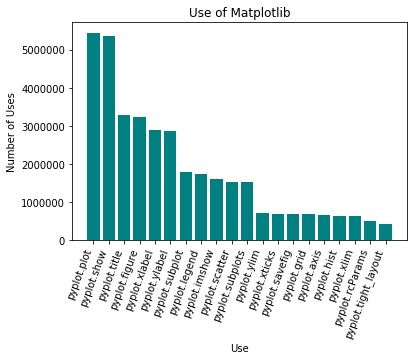

In [22]:
plot_package('matplotlib')

## Matplotlib and Seaborn: what types of plots are people using?

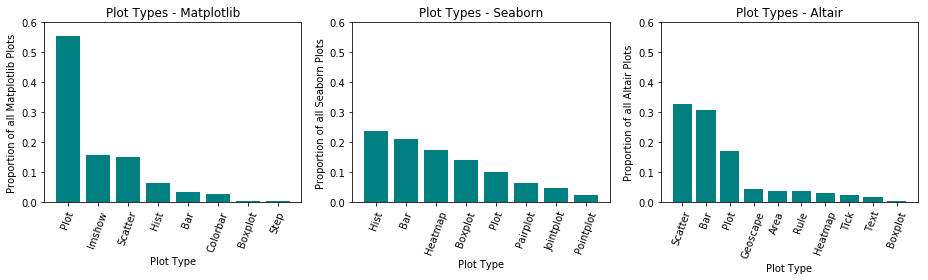

In [23]:
fig = plt.figure(figsize = (13, 4))
plt.subplot(1,3,1)
x = [m.title() for m in matplotlib_plot_counts['Plot Type']]
x_pos = np.arange(len(x))
height = matplotlib_plot_counts['Count']/matplotlib_plot_counts['Count'].sum()
plt.bar(x_pos, height, color = 'teal')
plt.xticks(x_pos, x, rotation = 70)
plt.xlabel('Plot Type')
plt.ylabel('Proportion of all Matplotlib Plots')
plt.ylim(0, 0.6)
plt.title('Plot Types - Matplotlib')

plt.subplot(1,3,2)
x = [s.title() for s in seaborn_plot_counts['Plot Type']]
x_pos = np.arange(len(x))
height = seaborn_plot_counts['Count']/seaborn_plot_counts['Count'].sum()
plt.bar(x_pos, height, color = 'teal')
plt.xticks(x_pos, x, rotation = 70) 
plt.xlabel('Plot Type')
plt.ylabel('Proportion of all Seaborn Plots')
plt.ylim(0, 0.6)
plt.title('Plot Types - Seaborn')

plt.subplot(1,3,3)
x = [a.title() for a in altair_plot_counts['Plot Type']]
x_pos = np.arange(len(x))
height = altair_plot_counts['Count']/altair_plot_counts['Count'].sum()
plt.bar(x_pos, height, color = 'teal')
plt.xticks(x_pos, x, rotation = 70) 
plt.xlabel('Plot Type')
plt.ylabel('Proportion of all Altair Plots')
plt.ylim(0, 0.6)
plt.title('Plot Types - Altair')
plt.tight_layout()
plt.show()

Histograms and bar charts are the most popular plot types in Seaborn. Opposite of Matplotlib, x vs y plots aren't extremely popular (used half as often as histograms).

## Matplotlib: are people annotating their plots?

Assuming that each occurance of a 'Plot Type' (see above) is *one plot*, I'm curious how frequently *titles*, *axis labels*, and *legends* are used in comparison

In [24]:
matplotlib_uses = get_counts('matplotlib')

In [25]:
num_plots = matplotlib_plot_counts.Count.sum()
def print_percent(feature):
    num = matplotlib_uses[matplotlib_uses.use == 'pyplot.{0}'.format(feature)]['count'].values[0]
    print("{0} are used on approximately {1}% of matplotlib plots.".format(
        feature.title() + 's' if not feature.endswith('s') else feature.title(),
        round(100*num/num_plots, 2)
    ))

In [26]:
print_percent('title')
print_percent('xlabel')
print_percent('ylabel')
print_percent('legend')
print_percent('xticks')
print_percent('yticks')


Titles are used on approximately 32.84% of matplotlib plots.
Xlabels are used on approximately 28.92% of matplotlib plots.
Ylabels are used on approximately 28.46% of matplotlib plots.
Legends are used on approximately 17.17% of matplotlib plots.
Xticks are used on approximately 6.79% of matplotlib plots.
Yticks are used on approximately 3.91% of matplotlib plots.


## Matplotlib: how many visualizations are typical in a notebook?

In [27]:
num_plots = matplotlib_plot_counts.Count.sum()
num_nbs = len(notebooks)

print("On average, there are {0} matplotlib visualizations per notebook.".format(
    round(num_plots/num_nbs,2)
))

On average, there are 2.32 matplotlib visualizations per notebook.


## Popularities Over Time

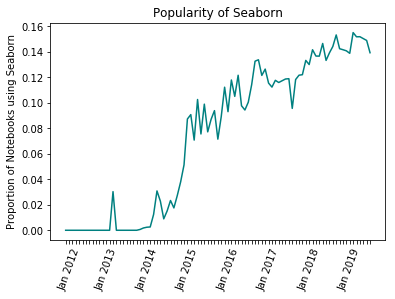

In [28]:
x = list(range(len(monthly_vis_counts)))[:-1]
y = monthly_vis_counts.seaborn[:-1] / monthly_vis_counts.total[:-1]
plt.plot(x, y, color = 'teal')
plt.xticks(x, monthly_vis_counts.label, rotation = 70)
plt.ylabel('Proportion of Notebooks using Seaborn')
plt.title('Popularity of Seaborn')
plt.show()

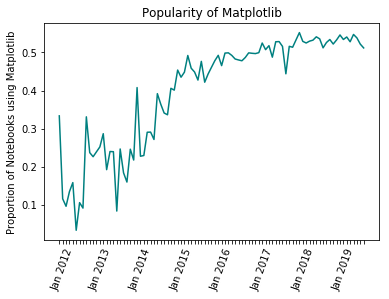

In [29]:
x = list(range(len(monthly_vis_counts)))[:-1]
y = monthly_vis_counts.matplotlib[:-1] / monthly_vis_counts.total[:-1]
plt.plot(x, y, color = 'teal')
plt.xticks(x, monthly_vis_counts.label, rotation = 70)
plt.ylabel('Proportion of Notebooks using Matplotlib')
plt.title('Popularity of Matplotlib')
plt.show()

The proportion of notebooks that use matplotlib had high variation in early months, likely due to the small number of notebooks. The popularity has grown dramatically from about 10% in June 2013 and looks to be converging to about *42% of all notebooks importing Matplotlib*.

<center> <a href = Models.ipynb>ML Model Use &lt;</a> | <a href = Struggles.ipynb>&gt; User Struggles</a> <center>